# DengAi

Predicción del número de casos de dengue mediante aprendizaje supervisado.

Datos obtenidos del sitio web de Driven Data.

**Participante**: Diego Pastor Bonet

**Datos del modelo final elegido**
* MAE test (DrivenData): 27.4543
* MAE validación: 18.46917808219178
* Algoritmo ML: Clustering K-means, Regresión Lineal
* Hiperparámetros:
  * n = 3
  * max_iter = 300
  * tol = 0.01
* Lista de características:

  * year
  * weekofyear
  * precipitation_amt_mm
  * reanalysis_air_temp_k
  * reanalysis_avg_temp_k
  * reanalysis_max_air_temp_k
  * reanalysis_min_air_temp_k
  * reanalysis_precip_amt_kg_per_m2
  * reanalysis_relative_humidity_percent
  * reanalysis_specific_humidity_g_per_kg
  * station_avg_temp_c
  * station_diur_temp_rng_c
  * station_max_temp_c
  * station_min_temp_c
  * station_precip_mm
  * season
  * city_bin
  * ndvi_avg
  * etiqueta

* Resumen dataset (transformaciones, etc.):
  * Binarización de la variable 'city' dando lugar a 'city_bin'.
  * Tratamiento de nulos con el método ffill, excepto en el caso de las variables ndvi que se ha hecho un promedio de los valores anteriores y siguientes no nulos.
  * Creación de las variables 'season' y 'ndvi_avg'
  * Eliminación de las variables 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'city', 'week_start_date', 'reanalysis_sat_precip_atm_mm', 'reanalysis_air_temp_k', 'reanalysis_dew_point_temp_k' y 'reanalysis_tdtr_k'.
  * Adición de las etiquetas correspondientes a los clusters generados por los algoritmos de agrupamiento.

---
# Resumen
---

A lo largo de este análisis se elaborará un modelo de predicción que podrá ser puestos a prueba en la web de DrivenData.

En primer lugar se hará un procesado teniendo en cuenta las necesidades estructurales de la competición.

Se escogerán los mejores candidatos a algoritmos de agrupamiento, a continuación, se probarán también varios modelos de predicción para encontrar el mejor posible. Finalmente, todo esto será puesto a prueba mediante un conjunto de validación y posteriormente por la web mediante un conjunto de test. La métrica que se utilizará para evaluar los modelos será el error absoluto medio (MAE) aportado por DrivenData.

El objetivo será alcanzar el menor valor de MAE entregando diferentes intentos con combinaciones de grupos de características y algoritmos a esta web.

En base a esta métrica, el conjunto de datos mejor valorado ha sido el conformado por el conjunto de datos original, al que se le ha añadido la etiqueta de cluster generada por el algoritmo K-Means con tres clusters. Este es además el algoritmo de agrupamiento que mejor resultado obtuvo en la práctica anetrior. El modelo de predicción que mejor ha funcionado es el de Regresión Lineal.

Otras combinaciones como una sub-selección de características, diferentes modelos de predicción o diferentes algoritmos de agrupamiento han dado todos peores resultados que éste, sin embargo, aún hay espacio para seguir investigando, especialmente con diferentes conjuntos de características.

---
# Inicialización
---

En esta sección se ejecuta código indispensable para la práctica.

Se trata de imports de librerías necesarias, creación de funciones y subidas de los archivos de entrenamiento y test.

*Es importante ejecutar las celdas de código en orden, no hacerlo puede provocar que algunas partes no funcionen correctamente.

In [ ]:
# Imports generales
import pandas as pd
import io
from google.colab import files
import numpy as np
import time
import matplotlib.pyplot as plt

def upload_files (index_fields=None):
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')), index_col = index_fields)

    return df

def download_predictions(test, pred_total_cases):
  file_name = "practica2_pred_" + time.strftime("%Y") + time.strftime("%m") + time.strftime("%d") + time.strftime("%H") + time.strftime("%M") + time.strftime("%S") + ".csv"
  predictions = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 'total_cases': pred_total_cases})
  with open(file_name, 'w') as f:
    predictions.to_csv(f, index = False)
  files.download(file_name)
  print("Downloaded " + file_name)

In [ ]:
# Subir el conjunto de entrenamiento sin variable objetivo (dengue_features_train.csv)
train_feat = upload_files()
print(train_feat.shape)
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes
(1456, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [ ]:
# Subir la variable objetivo total_cases del conjunto de entrenamiento (dengue_labels_train.csv)
train_labels = upload_files()

# Unificar el conjunto de entrenamiento (características + variable objetivo)
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
print(train.shape)
train.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes
(1456, 25)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [ ]:
# Subir el conjunto de test sin variable objetivo (dengue_features_test.csv)
test = upload_files()
print(test.shape)
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes
(416, 24)


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


---
# Preprocesado
---

En primer lugar, una vez tenemos los datos en bruto, se procede a modificar variables para adecuarlas al procesado de las siguientes secciones.

En primer lugar se toma la variable week_start_date y se transforma en tipo fecha, esto es para posteriormente, crear una variable basada en la estación del año.

Los algoritmos de agrupamiento que se utilizarán más adelante no aceptan valores no numéricos, por lo que habrá que eliminar esta variable fecha más adelante.

In [ ]:
#el atributo 'week_start_date' es formato string, lo pasamos a fecha
train['week_start_date'] = pd.to_datetime(train['week_start_date'], format='%Y-%m-%d')
test['week_start_date'] = pd.to_datetime(test['week_start_date'], format='%Y-%m-%d')

Por el motivo ya comentado de que los algoritmos no aceptan valores no numéricos, procedemos a transformar los valores de las dos ciudades en 0 o 1, es decir, las binarizamos, dando lugar a la variable 'city_bin'.

In [ ]:
#Binarizador para la variable categórica city.
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

train['city_bin'] = lb.fit_transform(train['city'])
test['city_bin'] = lb.fit_transform(test['city'])

Nótese que se ha ejecutado el código tanto para el set de entrenamiento como en el de test.

---
# Características
---

En esta sección se ejecutará código de procesado de características.

Se trata de creación de variables, eliminación de variables y tratamiento de nulos.

No se eliminan registros con demasiados nulos o tratamiento de outliers en general, esto es porque al final de la actividad, al subir el archivo a la plataforma del concurso, el archivo debe tener el número de registros original.

Respecto a los nulos, salvo en los atributos relacionados con NDVI, se ha procedido a utilizar el método ffill.

##Tratamiento de nulos

  * En primer lugar se tratan las variables NDVI obteniendo un promedio entre los valores anteriores y posteriores no nulos.

In [ ]:
#llenamos los valores nulos de ndvi:

#Train
train = train.reset_index(drop=True)

def fill_ndvi(df, columns):
    for column in columns:
        # Encuentra los índices de los valores nulos
        null_indices = df[column].isnull()

        # Itera a través de los índices nulos y actualiza los valores
        for i in null_indices[null_indices==True].index:
            # Encuentra el primer índice no nulo después del índice actual
            next_valid_index = df[column][i:].first_valid_index()
            if next_valid_index is None:
                # Si no hay valores no nulos después del índice actual, no se puede hacer nada
                break
            elif next_valid_index >= len(df):
                # Si el índice siguiente es mayor que la longitud del dataframe, no se puede hacer nada
                break
            # Calcula el promedio entre el valor anterior no nulo y el primer valor no nulo después
            avg = (df[column][i-1] + df[column][next_valid_index]) / 2
            # Actualiza el valor nulo con el promedio
            df.loc[i, column] = avg

    return df

columns = ['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'] #se aplica a estas columnas
train = fill_ndvi(train, columns)

#------------------------------------

#Test
test = test.reset_index(drop=True)
test = fill_ndvi(test, columns)

  * A continuación se trata el resto de nulos mediante el método ffill:

In [ ]:
#se procede a rellenar los nulos
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)

##Creación de variables

Creamos dos variables a partir de los datos que ya tenemos.

Se trata de la columna 'estación' y la columna 'ndvi_avg'.

In [ ]:
#Cramos la columna de estación
train['season'] = (train['week_start_date'].dt.month % 12 + 3) // 3
test['season'] = (test['week_start_date'].dt.month % 12 + 3) // 3
#0: invierno, 1: primavera, 2: verano, 3: otoño

#Creamos una columna que agrupe los factores ndvi en un único factor con los promedios:
train['ndvi_avg'] = train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)
test['ndvi_avg'] = test[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']].mean(axis=1)

##Eliminación de variables

Se eliminan las variables por motivos explicados anteriormente.

In [ ]:
#Borramos las cuatro columnas ndvi originales
train.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)
test.drop(['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw'], axis=1, inplace=True)

#Eliminamos la columna string 'city'
train = train.drop('city', axis=1)
test = test.drop('city', axis=1)

#Eliminamos la columna date 'week_start_date'
train = train.drop('week_start_date', axis=1)
test = test.drop('week_start_date', axis=1)

#Eliminamos la columna date 'reanalysis_sat_precip_amt_mm'
train = train.drop('reanalysis_sat_precip_amt_mm', axis=1)
test = test.drop('reanalysis_sat_precip_amt_mm', axis=1)

#Eliminamos la columna date 'reanalysis_air_temp_k'
train = train.drop('reanalysis_air_temp_k', axis=1)
test = test.drop('reanalysis_air_temp_k', axis=1)

#Eliminamos la columna date 'reanalysis_dew_point_temp_k'
train = train.drop('reanalysis_dew_point_temp_k', axis=1)
test = test.drop('reanalysis_dew_point_temp_k', axis=1)

#Eliminamos la columna date 'reanalysis_tdtr_k'
train = train.drop('reanalysis_tdtr_k', axis=1)
test = test.drop('reanalysis_tdtr_k', axis=1)

##Separación del conjunto de validación

Adicionalmente, se separa del conjunto de entrenamiento un pequeño conjunto de validación que se empleará para tener un MAE alternativo al obtenido de la página web. Los algoritmos de entrenamiento no verán este conjunto de validación.

Esto es útil puesto que contamos con datos etiquetados, a los que podemos quitar la etiqueta durante la validación y posteriormente comprobar los resultados con la misma.

Se realiza esta separación en este momento puesto que ya está tratado el conjunto de entrenamiento, por lo tanto no es necesario volver a aplicar las transformaciones al de validación.

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.2, random_state=123)

Estos son los conjuntos con los que contamos y sus tamaños:

In [ ]:
print('Conjunto de test: ' + str(test.shape))
print('Conjunto de entrenamiento: ' + str(train.shape))
print('Conjunto de validación: ' + str(validation.shape))

Conjunto de test: (416, 17)
Conjunto de entrenamiento: (1164, 18)
Conjunto de validación: (292, 18)


##Normalización de las variables

Previo al análisis de agrupamiento con diferentes algoritmos es necesario normalizar los valores de los atributos del set de entrenamiento.

Esto se debe a que este tipo de algoritmos tiende a valorar más la aportación de una variable con un valor muy elevado por encima de otra variable que tomas valores pequeños.

Para evitar este sesgo, se reescalan todos los valores del dataset:

In [ ]:
#Normalización con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
original_train=train

train = train.drop("total_cases", axis = 1)
train = scaler.fit_transform(train)

*Esta normalización sólo se utilizará para los algoritmos de agrupamiento

---
# Predicción
---

En esta sección emplearemos técnicas de agrupamiento para dotar los registros del dataset con etiquetas que nos permitan mejorar la capacidad de predicción del número de casos. Se utilizarán algoritmos de agrupamiento.

Fijamos la semilla de valores aleatorios para que los resultados obtenidos por mí en un primer momento se reproduzcan de igual forma siempre que sean ejecutados por cualquiera.

In [ ]:
np.random.seed(123)

##K-Means

El primer algoritmo de agrupamiento que utilizamos es K-Means, pues se trata del que mejor se comportó en la actividad anterior, obteniendo un mejor resultado del índice de Davies-Bouldin.

###Método del codo

Para optimizar de forma sencilla y directa el número de clusters tenemos el método del codo. El punto de inflexión del "codo" nos indica el valor óptimo del número de clusters para nuestro dataset.

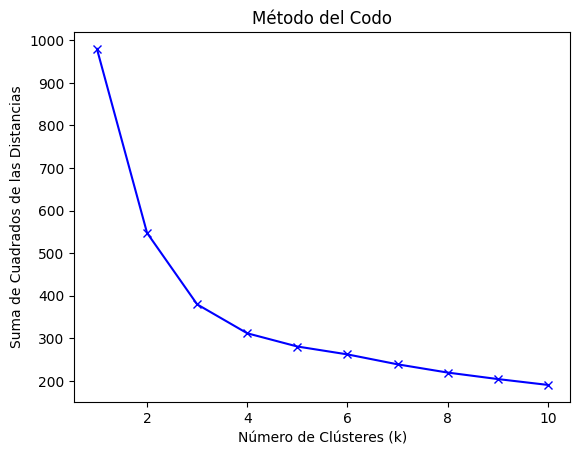

In [ ]:
#K-means - número de clusters, método del codo
from sklearn.cluster import KMeans

ssd = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init = 10, random_state=42)
    kmeans.fit(train)
    ssd.append(kmeans.inertia_)
plt.plot(range(1, 11), ssd, 'bx-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Suma de Cuadrados de las Distancias')
plt.title('Método del Codo')
plt.show()

A través del gráfico podemos ver que el punto de inflexión se encuentra en 3, aunque se podría valorar utilizar 2 puesto que hay gran diferencia respecto a 1 y poca respecto a 3. Se pueden probar ambos y utilizar alguna métrica para valorar cuál es mejor.

###Parámetro n = 3

Vamos a ejecutar el algoritmo para número de clusters n = 3 y a visualizar el resultado.

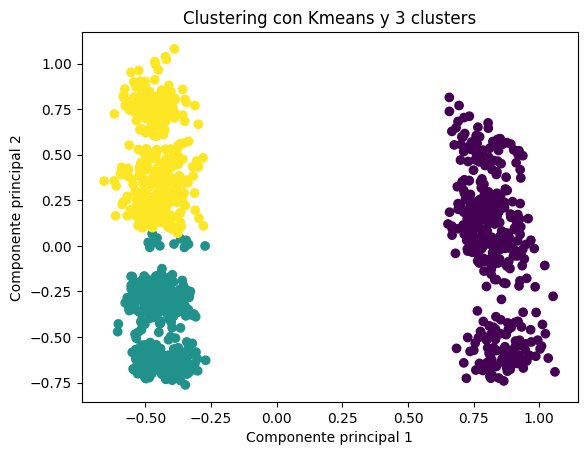

In [ ]:
#K-Means n = 3
kmeans = KMeans(n_clusters=3, n_init=10, max_iter = 300, tol = 0.01)
kmeans.fit(train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)
X_pca = np.hstack((X_pca, labels.reshape(-1, 1)))

#Visualizamos
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=X_pca[:, 2])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clustering con Kmeans y 3 clusters')
plt.show()

#----------
kmeans_n3 = kmeans

In [ ]:
train_kmeans_n3 = original_train
train_kmeans_n3['etiquetas']= kmeans.labels_

####Validación

Para escoger un algoritmo se emplea el índice de Davies-Bouldin. Este índice mide el nivel de compactación de los clusters y el objetivo es minimizar su valor.

In [ ]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(train, labels)
print("El índice de Davies-Bouldin es:", db_index)

El índice de Davies-Bouldin es: 0.9565319148612845


###Parámetro n = 2

Por completitud vamos a analizar el caso con número de clusters n = 2, puesto que en el método del codo también sale bien parado este valor. Es necesario hacer esta comparación para optimizar este hiperparámetro.

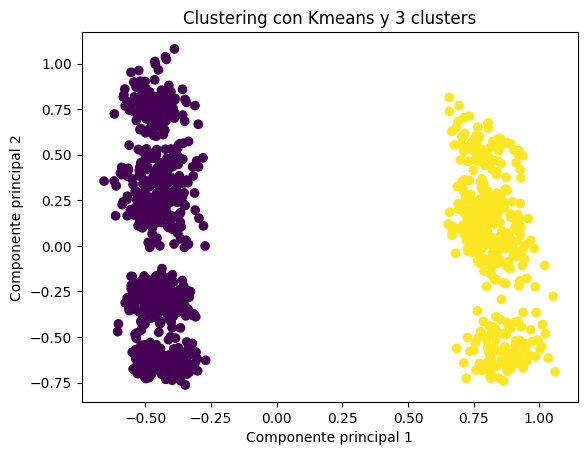

In [ ]:
#K-Means n = 2
kmeans = KMeans(n_clusters=2, n_init=10, max_iter = 300, tol = 0.01)
kmeans.fit(train)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Reducción de dimensionalidad con PCA
from sklearn.decomposition import PCA
import numpy as np
pca = PCA(n_components=2)
X_pca = pca.fit_transform(train)
X_pca = np.hstack((X_pca, labels.reshape(-1, 1)))

#Visualizamos
plt.scatter(x=X_pca[:, 0], y=X_pca[:, 1], c=X_pca[:, 2])
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Clustering con Kmeans y 3 clusters')
plt.show()

#-------------
kmeans_n2 = kmeans

In [ ]:
train_kmeans_n2 = original_train
train_kmeans_n2['etiquetas']= kmeans.labels_

####Validación

In [ ]:
from sklearn.metrics import davies_bouldin_score
db_index = davies_bouldin_score(train, labels)
print("El índice de Davies-Bouldin es:", db_index)

El índice de Davies-Bouldin es: 1.0386687890735002


El resultado es algo peor que el anterior, parece que el mejor resultado lo sustenta n = 3.

##Análisis basado en densidad

En esta sección se emplea la alternativa a K-Means, pese a que fue el mejor resultado de la actividad anterior vamos a añadir variedad empleando DBSCAN. Es importante añadir variedad para aumentar las posibilidades de hallar el mejor resultado.

Text(0, 0.5, 'PC2')

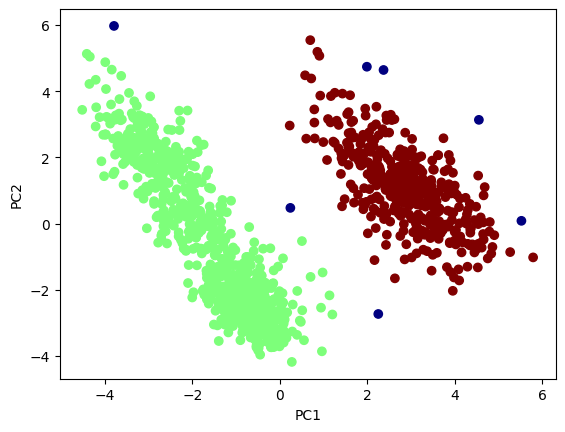

In [ ]:
#DBSCAN

#PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
X = scaler.fit_transform(train)

from sklearn.decomposition import PCA
PCA = PCA(n_components=2)
components = PCA.fit_transform(X)

cumVar = pd.DataFrame(np.cumsum(PCA.explained_variance_ratio_)*100,
                      columns=["cumVarPerc"])
expVar = pd.DataFrame(PCA.explained_variance_ratio_*100, columns=["VarPerc"])
pd.concat([expVar, cumVar], axis=1)\
    .rename(index={0: "PC1", 1: "PC2"})

#---------------

#Algoritmo
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples = 3)
clusters = dbscan.fit_predict(components)
#plot the cluster assignments
plt.scatter(components[:, 0], components[:, 1], c=clusters, cmap='jet')
plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
train_dbscan = original_train
train_dbscan['etiquetas'] = clusters

###Validación

In [ ]:
#Índice Davies-Bouldin (DB)
from sklearn.metrics import davies_bouldin_score
score= davies_bouldin_score(components, clusters)
score

2.5056350732678134

Se obtiene un resultado bastante peor que los anteriores resultados de K-Means.

---
#Creación de distintos modelos
---

En esta sección crearemos varios modelos de aprendizaje supervisado para el resultado final. No tenemos a priori ninguna pista de cual es el mejor algoritmo por lo que probaremos varios de ellos.

Entrenaremos los modelos con los datos etiquetados resultantes del clustering K-Means de tres clusters, pues es el que mejor resultado ha dado.

##SVM

El primer modelo será basado en Máquinas de Vectores de Soporte (SVMs).

In [ ]:
X_train = train_kmeans_n3
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn import svm
svm_kmeans_n3 = svm.SVR()
svm_kmeans_n3.fit(X_train, Y_train)

SVR()

##KNN

El segundo modelo es el de K-Vecinos más cercanos. Probaremos con un valor de K = 5.

In [ ]:
X_train = train_kmeans_n3
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn.neighbors import KNeighborsRegressor
knn_kmeans_n5 = KNeighborsRegressor(n_neighbors=5)
knn_kmeans_n5.fit(X_train, Y_train)

KNeighborsRegressor()

##Árbol de decisión

A continuación entrenamos un modelo de árbol de decisión.

In [ ]:
X_train = train_kmeans_n3
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn.tree import DecisionTreeRegressor
tree_kmeans_n3 = DecisionTreeRegressor(random_state=0)
tree_kmeans_n3.fit(X_train, Y_train)

DecisionTreeRegressor(random_state=0)

##Regresión lineal

Finalmente entrenamos un modelo de Regresión lineal.

In [ ]:
X_train = train_kmeans_n3
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn import linear_model
regres_kmeans_n3 = linear_model.LinearRegression()
regres_kmeans_n3.fit(X_train, Y_train)

LinearRegression()

---
# Generación del Resultado Final
---

Generamos el fichero de salida de los diferentes modelos según el Submission format.

Realizamos las predicciones sobre el test.

Se emplearán todos los modeloes entrenados y posteriormente se optimizará el mejor de ellos.

##SVM

In [ ]:
X_test = test
#X_test = X_test.drop('etiquetas', axis=1)  #Si se vuelve a ejecutar esta parte del código, se puede necesitar esta línea
X_test["etiquetas"] = kmeans_n3.predict(X_test)
y_pred = svm_kmeans_n3.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
#Generar output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('svm_kmeans_n3.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('svm_kmeans_n3.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,12
2,sj,2008,20,12
3,sj,2008,21,12
4,sj,2008,22,12


En la web de la competición se obtiene un MAE de 32.6130.

Se puede considerer como un resultado malo debido a que supera el 30. Para tener un buen resultado consideramos que debemos bajar al menos de 28.

###Calculamos el MAE de validación

Este MAE es el calculado utilizando un conjunto de datos de validación que ha sido separado del conjunto de enrenamiento para este propósito.

In [ ]:
real = validation['total_cases']
validation_svm_kmeans_n3 = validation
validation_svm_kmeans_n3 = validation_svm_kmeans_n3.drop('total_cases', axis=1)
validation_svm_kmeans_n3["etiquetas"] = kmeans_n3.predict(validation_svm_kmeans_n3)

y_pred = svm_kmeans_n3.predict(validation_svm_kmeans_n3)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 16.767123287671232



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


El MAE de validación es sustancialmente menor al obtenido de la web de la competición.

##KNN

In [ ]:
X_test = test
X_test = X_test.drop('etiquetas', axis=1)
X_test["etiquetas"] = kmeans_n3.predict(X_test)
y_pred = knn_kmeans_n5.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
#Generar output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('knn_kmeans_n5.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('knn_kmeans_n5.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,11
1,sj,2008,19,8
2,sj,2008,20,9
3,sj,2008,21,7
4,sj,2008,22,6


En la web del concurso hemos obtenido un MAE de 30.7981.

Este resultado es mejor que el obtenido mediante SVM pero aún estamos fuera del umbral que buscamos.

###Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_knn_kmeans_n5 = validation
validation_knn_kmeans_n5 = validation_knn_kmeans_n5.drop('total_cases', axis=1)
validation_knn_kmeans_n5["etiquetas"] = kmeans_n3.predict(validation_knn_kmeans_n5)

y_pred = knn_kmeans_n5.predict(validation_knn_kmeans_n5)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 16.565068493150687



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


En este caso el MAE de validación es incluso inferior.

##Árbol de decisión

In [ ]:
X_test = test
X_test = X_test.drop('etiquetas', axis=1)
X_test["etiquetas"] = kmeans_n3.predict(X_test)
y_pred = tree_kmeans_n3.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
#Generar output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('tree_kmeans_n3.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('tree_kmeans_n3.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,1
1,sj,2008,19,2
2,sj,2008,20,1
3,sj,2008,21,5
4,sj,2008,22,8


En la web de la competición se obtiene un MAE de 30.9351.

De nuevo es un mal resultado.

###Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_tree_kmeans_n3 = validation
validation_tree_kmeans_n3 = validation_tree_kmeans_n3.drop('total_cases', axis=1)
validation_tree_kmeans_n3["etiquetas"] = kmeans_n3.predict(validation_tree_kmeans_n3)

y_pred = tree_kmeans_n3.predict(validation_tree_kmeans_n3)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 13.852739726027398



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Este es el más bajo de los MAE de validación de los hallados hasta ahora, no parecen estar en consonancia con los valores de la página web.

##Regresión

In [ ]:
X_test = test
X_test = X_test.drop('etiquetas', axis=1)
X_test["etiquetas"] = kmeans_n3.predict(X_test)
y_pred = regres_kmeans_n3.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
# generate output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

#Para adecuar el resultado al formato del concurso
output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('kmeans_n3.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('kmeans_n3.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,14
1,sj,2008,19,12
2,sj,2008,20,16
3,sj,2008,21,12
4,sj,2008,22,19


En esta ocasión hemos obtenido en la web un MAE de 27.4543.

Por primera vez hemos superado el umbral de mejora situándonos por debajo de 28.

####Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_kmeans_n3 = validation
validation_kmeans_n3 = validation_kmeans_n3.drop('total_cases', axis=1)
validation_kmeans_n3["etiquetas"] = kmeans_n3.predict(validation_kmeans_n3)

y_pred = regres_kmeans_n3.predict(validation_kmeans_n3)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 18.46917808219178



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


El MAE de validación es de nuevo sustancialmente inferior al de la página web.

El modelo de regresión Lineal ha resultado sin duda el mejor de los algoritmos utilizados.
Llegados a este punto vamos a optimizar el modelo de regresión.

##Optimización del modelo

Tomando el modelo de regresión como el mejor hasta el momento una de las cosas que podemos hacer es cambiar el parámetro de número de clusters de k-means a 2, de manera que cambiamos una de las características del mdoelo y obtenemos un modelo nuevo:

In [ ]:
X_train = train_kmeans_n2
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn import linear_model
regres_kmeans_n2 = linear_model.LinearRegression()
regres_kmeans_n2.fit(X_train, Y_train)

LinearRegression()

Podemos hacer lo mismo aprovechando los clusters generados por DBSCAN en el análisis de agrupamiento por densidad y generar otro modelo:

In [ ]:
X_train = train_dbscan
X_train = X_train.drop("total_cases", axis=1)
Y_train = train_dbscan["total_cases"]

from sklearn import linear_model
regres_dbscan = linear_model.LinearRegression()
regres_dbscan.fit(X_train, Y_train)

LinearRegression()

###kmeans n = 2

In [ ]:
X_test = test
X_test = X_test.drop('etiquetas', axis=1)
X_test["etiquetas"] = kmeans_n2.predict(X_test)
y_pred = regres_kmeans_n2.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
#Generar output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('kmeans_n2.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('kmeans_n2.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,16
1,sj,2008,19,13
2,sj,2008,20,17
3,sj,2008,21,14
4,sj,2008,22,21


En esta ocasión se obtiene de la web de la competición un MAE de 29.5697.

No se ha conseguido mejorar el resultado mediante este cambio.

####Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_kmeans_n2 = validation
validation_kmeans_n2 = validation_kmeans_n2.drop('total_cases', axis=1)
validation_kmeans_n2["etiquetas"] = kmeans_n2.predict(validation_kmeans_n2)

y_pred = regres_kmeans_n2.predict(validation_kmeans_n2)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 19.17808219178082



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


También se empeora el resultado respecto a la versión con 3 clusters.

###DBSCAN

In [ ]:
X_test = test
X_test = X_test.drop('etiquetas', axis=1)

components = PCA.fit_transform(X_test)

X_test["etiquetas"] = dbscan.fit_predict(components)
y_pred = regres_dbscan.predict(X_test)

* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
#Generar output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('dbscan.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('dbscan.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,10
2,sj,2008,20,14
3,sj,2008,21,10
4,sj,2008,22,17


Se obtiene de la web un MAE de 29.9904.

Este cambio tampoco mejora el valor original de K-Means con 3 clusters.

####Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_dbscan = validation
validation_dbscan = validation_dbscan.drop('total_cases', axis=1)

components = PCA.fit_transform(validation_dbscan)
validation_dbscan["etiquetas"] = dbscan.fit_predict(components)

y_pred = regres_dbscan.predict(validation_dbscan)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 17.835616438356166



El resultado es también peor en el caso de MAE de validación.

###Reducción de Características

Otra de las posibles mejoras al modelo puede venir de la reducción del número de características empleadas. Una cantidad excesivamente grande de características puede afectar negativamente el rendimiento de estos modelos por lo que se procede a reducirlo eliminando atributos que se consideran irrelevantes.

In [ ]:
X_train = train_kmeans_n3
X_train = X_train.drop(["total_cases", 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1)
Y_train = train_kmeans_n3["total_cases"]

from sklearn import linear_model
regres_kmeans_n3_reduct = linear_model.LinearRegression()
regres_kmeans_n3_reduct.fit(X_train, Y_train)

LinearRegression()

Se han escogido estas características para ser eliminadas dado que se refieren a medidas de temperatura y humedad, que ya se ven representadas por otras variables del conjunto. Es un proceso de selección meramente intuitivo.

In [ ]:
X_test = test
X_test = X_test.drop("etiquetas", axis = 1)
X_test["etiquetas"] = kmeans_n3.predict(X_test)

X_test = X_test.drop(['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1)


y_pred = regres_kmeans_n3_reduct.predict(X_test)

test = test.drop('etiquetas', axis = 1)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


* Redondeamos el resultado

In [ ]:
# round the result and cast to int
import numpy as np
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)

In [ ]:
y_pred_no_neg = res.copy()

In [ ]:
y_pred_no_neg[y_pred < 0] = 0

* Generamos el fichero de salida

In [ ]:
# generate output
output = pd.DataFrame({ 'city': test['city_bin'], 'year': test['year'], 'weekofyear': test['weekofyear'],
                       'total_cases': y_pred_no_neg})

#Para adecuar el resultado al formato del concurso
output['city'] = output['city'].replace({0: 'iq', 1: 'sj'})


from google.colab import files

with open('kmeans_n3_reduct.csv', 'w') as f:
  output.to_csv(f,  index = False)


files.download('kmeans_n3_reduct.csv')

output.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,13
2,sj,2008,20,16
3,sj,2008,21,13
4,sj,2008,22,15


En esta ocasión hemos obtenido en la web un MAE de 29.9591.

Esta reducción de características tampoco ha beneficiado al modelo.

El mejor valor obtenido sigue siendo 27.4543.

####Calculamos el MAE de validación

In [ ]:
real = validation['total_cases']
validation_kmeans_n3 = validation
validation_kmeans_n3 = validation_kmeans_n3.drop('total_cases', axis=1)
validation_kmeans_n3["etiquetas"] = kmeans_n3.predict(validation_kmeans_n3)

validation_kmeans_n3 = validation_kmeans_n3.drop(['reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c', 'station_max_temp_c', 'station_min_temp_c'], axis=1)

y_pred = regres_kmeans_n3_reduct.predict(validation_kmeans_n3)
y = np.rint(y_pred) # round
y = y.astype(int) # cast to int
res = np.hstack(y)
y_pred_no_neg = res.copy()
y_pred_no_neg[y_pred < 0] = 0

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(real, y_pred_no_neg)
print('MAE de validación: ' + str(mae))
print("")

MAE de validación: 18.828767123287673



/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Se ha obtenido un resultado en la línea de lo que se está obteniendo con el resto de modelos, el cambio de características no ha supuesto ninguna mejora.

---
# Conclusiones
---

| Modelo | MAE test (DrivenData) | MAE validación | Algoritmo | Hiperparámetros |
| --- | --- | --- | --- | ---
| svm_kmeans_n3 | 32.6130 | 16.7671 | K-Means - SVM | n_clusters=3, n_init=10, max_iter = 300, tol = 0.01
| knn_kmeans_n5 | 30.7981 | 16.5651 | K-Means - KNN | n_neighbors=5, n_clusters=3, n_init=10, max_iter = 300, tol = 0.01
| tree_kmeans_n3 | 30.9351 | 13.8527 | K-Means - Árbol de decisión | random_state=0, n_clusters=3, n_init=10, max_iter = 300, tol = 0.01
| regres_kmeans_n3 | 27.4543 | 18.4692 | K-Means - Regresión Lineal | n_clusters=3, n_init=10, max_iter = 300, tol = 0.01
| regres_kmeans_n2 | 29.5697 | 19.1781 | K-Means - Regresión Lineal | n_clusters=2, n_init=10, max_iter = 300, tol = 0.01
| regres_dbscan  | 29.9904 | 17.8356 | DBSCAN - Regresión Lineal | eps=0.7, min_samples = 3
| regres_kmeans_n3_reduct | 29.9591 | 18.8288 | K-Means - Regresión Lineal | n_clusters=3, n_init=10, max_iter = 300, tol = 0.01

Respecto a las características empleadas, los modelos svm_kmeans_n3, knnkmeans_n5, tree_kmeans_n3, regres_kmeans_n3, regres_kmeans_n2* y regres_dbscan** han empleado las caractrísticas siguientes:
* year
* weekofyear
* precipitation_amt_mm
* reanalysis_air_temp_k
* reanalysis_avg_temp_k
* reanalysis_max_air_temp_k
* reanalysis_min_air_temp_k
* reanalysis_precip_amt_kg_per_m2
* reanalysis_relative_humidity_percent
* reanalysis_specific_humidity_g_per_kg
* station_avg_temp_c
* station_diur_temp_rng_c
* station_max_temp_c
* station_min_temp_c
* station_precip_mm
* season
* city_bin
* ndvi_avg
* etiquetas

*Respecto a regres_kmeans_n2, el valor de 'etiquetas' es el correspondiente al del algoritmo K-Means con 2 clusters.

*Respecto a regres_dbscan, el valor de 'etiquetas es el correspondiente al del algoritmo 'DBSCAN'.

El resto de modelos emplea las etiquetas correspondientes al algoritmo K-Means con 3 clusters.

En el caso del modelo regres_kmeans_n3_reduct, se han eliminado algunas características, por lo que se queda con las siguientes:
* year
* weekofyear
* precipitation_amt_mm
* reanalysis_air_temp_k
* reanalysis_avg_temp_k
* reanalysis_relative_humidity_percent
* station_diur_temp_rng_c
* station_precip_mm
* season
* city_bin
* ndvi_avg
* etiquetas

El modelo elegido es por tanto regres_kmeans_n3 puesto que obtiene el mejor resultdo en la validación de MAE de la página web de DrivenData.

Al poder contar con varios algoritmos de aprendizaje supervisado, como lo son SVM, KNN, el Árbol de decisión o la Regrsión Lineal hemos sido capaces de identificar cuál genera mejor resultado y proceder a optimizarlo.

Lo mismo ha sucedido con los algoritmos de agrupamiento que utilizamos en la actividad anterior. En esta actividad ya fueron validados y se seleccionó el mejor, pero se le ha dado una nueva oportunidad al DBSCAN y se ha probado a utilizar dos clsuters en K-Means.

Ha sido sorprendente el pobre resultado que ha tenido el modelo regres_kmeans_n3_reduct, pues se esperaba que el hecho de reducir el número de características iba a afectar positivamente al modelo. Al final no ha ocurrido así, muy posiblemente porque no se ha hecho la selección más adecuada de características.

Cabe señalar que las evaluaciones de MAE en el conjunto de validación no se correlacionan con las de la web, esto es curioso dado que los datos del conjunto de validación no alimentan los modelos y no debería haber overfitting.

Sin embargo, a la vista de los resultados, queda claro que se ha incurrido en alguna clase de sesgo durante la elaboración de los modelos, tal vez algún overfitting que no somos capaces de detectar.

Cabe también mencionar que durante la optimización de hiperparámetros del algoritmo K-Means, la variación de los parámetros n_init, max_iter y tol (iniciación de centroides, número máximo de iteraciones y tolerancia) no afecta nada en absoluto a los resultados de los clusters. Esto puede ser porque los clusters están muy bien separados y existe una tendencia muy marcada a alcanzar ese resultado que no puede ser modificada por estos parámetros.

El resultado final de MAE = 27.4543 de DrivenData se considera exitoso puesto que supera la barrera de 28.9111 impuesta por el profesor.
Es posible que se pudiera haber mejorado aún más mediante nuevas selecciones de características distintas a la realizada, sin embargo, la limitación de intentos en la página web ha sido un escollo en este aspecto.

##Trabajo Futuro

Se podría ahondar mucho más en la selección de características ahora que se tiene claro un buen algoritmo de agrupamiento y un buen algoritmo de regresión.

Con una cantidad suficiente de pruebas y ensayos con diferentes colecciones de características se alcanzaría un MAE aún más bajo.

---
# Competición
---

Se han empleado dos cuentas para poder subir varios ficheros al día y superar la limitación de 3.

En las imágenes se puede ver el nombre de usuario y las puntuaciones obtenidas.

Primera cuenta:

Nombre de usuario: diegopastorbonet

Los primeros tres resultados se corresponden con errores de formato.

El resultado resaltado es el mejor resultado obtenido de entre todos los modelos.

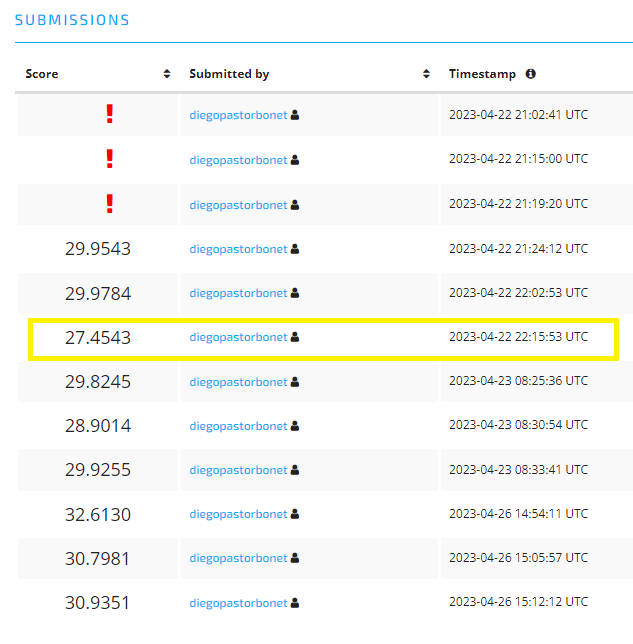

Segunda cuenta:

Nombre de usuario: diego.pastor

En esta segunda cuenta se han seguido subiendo archivos para superar la limitación.

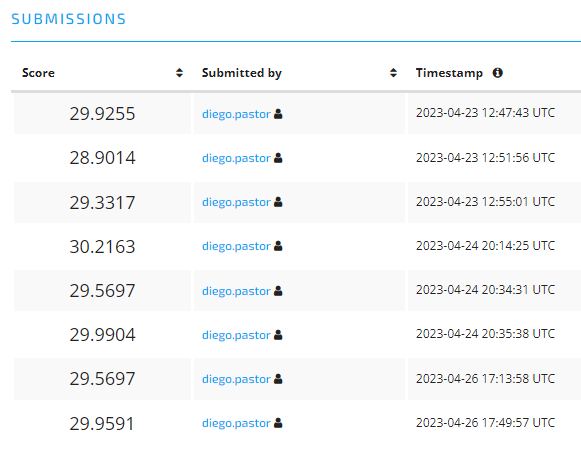

Mejor resultado:

Corresponde a la cuenta diegopastorbonet.

Este resultado corresponde al modelo regres_kmeans_n3.

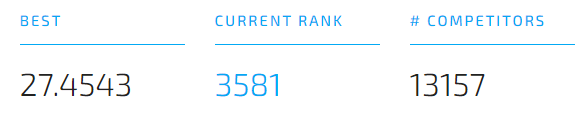